# Test MMC forcing

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC
import postproamrwindsample_xarray as ppsamplexr

# Load the libraries
import numpy as np
import pandas as pd
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import CubicSpline

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [3]:
# Location of precursor run with boundary data
precursordir  = '/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/PrecursorLayout/MMC_BM1_BigPrecursor/'
precursorsetup= precursordir+'/abl_MMC_Precursor.inp'

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict()

In [4]:
#case.setAMRWindInput('time_control', ['const dt'])
case.setAMRWindInput('time.fixed_dt',  0.10)
case.setAMRWindInput('ABL.stats_output_frequency', 10)

In [5]:
# Set the restart point
chkdir = precursordir+'/chk48000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [6]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics00000.nc'
forcingdict = {'ablstatfile':ablstatfile, 'tendencyforcing_file':'./tendencyforcing.nc'}
inflowplanes= ['xhi', 'ylo'] #['ylo', 'xhi']
bndryfiles  = precursordir+'/bndry_file/'

In [7]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           autoset_BodyForcing=False,
                           autoset_MMCForcing=False,
                           autoset_MMCTendencyForcing=True,
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/gpfs/lcheung/AWAKEN/Benchmark1/Phase1/PrecursorLayout/MMC_BM1_BigPrecursor//bndry_file/'
SET ABL_bndry_planes = ['ylo', 'xhi']
SET is_periodicx = False
SET is_periodicy = False
SET xhi_type = 'mass_inflow'
SET xhi_density = 1.103707
SET xhi_temperature = 0.0
SET xhi_tke = 0.0
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.103707
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET xlo_type = 'pressure_outflow'
SET xlo_density = None
SET xlo_temperature = None
SET xlo_tke = None
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET ABLForcing = False
Wrote ./tendencyforcing.nc
SET ABL_tendency_forcing = True
SET ABL_mesoscale_forcing = './tendencyforcing.nc'
SET ABLMesoForcingMom = True
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'
SET checkpoint_start = 48000


## Add Turbines

In [8]:
WS     = 10.05         # Wind speed, m/s
WDir   = 180           # Wind direction, degrees
farm_domainsize = [3.5*10240.0, 3*10240.0, 960]
farm_center     = [635000, 4.0235E6]   # In utm
#print(utm.from_latlon(36.587395, -97.756294))
#farm_center          = utm.to_latlon(640000, 4030000, 14, 'S')
print("Farm center = "+repr(farm_center)) # in lat/long
farm_background_mesh = 10 

Farm center = [635000, 4023500.0]


In [9]:
summitcsv = 'turbines.csv'
outputcsv = 'turbines_farmrun.csv'

inityaw = 160.0
typereplace = {'Summit_GE2.8-127':'NREL 2.8-127 ADM AWAKEN',
               'Summit_GE1.79-100':'NREL GE1.79-100 Joukowski Jul2024',
               'Summit_GE2.3-116':'NREL GE2.3-116v2 Joukowski Jul2024',
               'Summit_GE1.7-103':'NREL GE1.72-103 Joukowski Jul2024',
}

OFoptions = (
    "EDparam_YawDOF:False "
    "AMRparam_Actuator_openfast_stop_time:8000.0 "
    "FSTparam_DT_Out:0.5 "   #"FSTparam_DT_Out:1 "
    "FSTparam_TStart:0.0 "
    "EDparam_BlPitch(1):0.0 "
    "EDparam_BlPitch(2):0.0 "
    "EDparam_BlPitch(3):0.0 "
)

JDiskoptions = (
    "AMRparam_Actuator_epsilon:[5;5;5] "
    "AMRparam_Actuator_output_frequency:1 "
)

In [10]:
# Process the csv file
df = pd.read_csv(summitcsv)

# Fix the turbine types of the turbines
for index, row in df.iterrows():
    df.loc[index, ' yaw']=inityaw
    turbtype = df.loc[index, ' type']
    df.loc[index, ' type'] = typereplace[turbtype.strip()]
    if turbtype.strip() == "Summit_GE2.8-127":
        df.loc[index, ' options'] = OFoptions
    else:
        df.loc[index, ' options'] = JDiskoptions
    
df.to_csv(outputcsv, index=False)
#print(df)
#    if row['turbine_qc_id'].startswith('WIT_USKPL_SS001'):
#        df.loc[index, 'Unnamed: 0']='King Plains'
#    if row['turbine_qc_id'].startswith('WAF1'):
#        df.loc[index, 'Unnamed: 0']='Armadillo Flats'

In [11]:
case.loadTurbineCSVFile(outputcsv)

In [12]:
case.setAMRWindInput('turbines_coordsys', 'utm')

## Set up the domain 
case.setAMRWindInput('turbines_domainsize',         farm_domainsize)
case.setAMRWindInput('turbines_backgroundmeshsize', farm_background_mesh)
case.setAMRWindInput('turbines_autocalccenter',     False)
case.setAMRWindInput('turbines_farmcenter',         [farm_center[0], farm_center[1]])
case.setAMRWindInput('turbines_deleteprev', True)

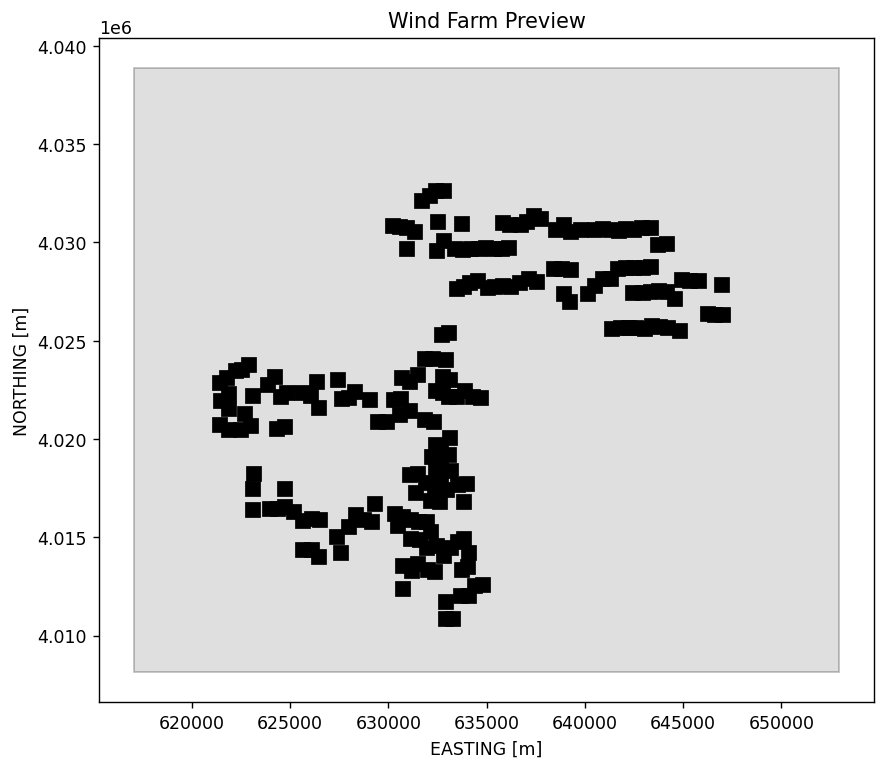

In [13]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=125)
case.setAMRWindInput('turbines_plotnames', False)
#case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.turbines_previewAllTurbines(ax=ax)

#rect = patches.Rectangle((turb_inside_box[0][0], turb_inside_box[1][0]), 
#                         turb_inside_box[0][1]-turb_inside_box[0][0], 
#                         turb_inside_box[1][1]-turb_inside_box[1][0], linewidth=1, edgecolor='k', linestyle='--', facecolor='none')
#ax.add_patch(rect)

In [14]:
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(len(case.listboxpopupwindict['listboxactuator'].getitemlist()))

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT001_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT001_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT001_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT002_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT002_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit

     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]


MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT003_OpenFAST_NREL2p8-127_AWAKEN


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT003_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT003_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT004_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT004_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT004_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT005_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT005_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT005_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT006_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT006_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT006_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT007_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT007_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT007_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT008_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT008_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT008_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT009_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT009_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT009_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT010_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT010_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT010_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT011_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT011_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit

     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT012_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT012_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT012_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT013_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT013_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT013_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT014_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT014_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT014_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT015_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT015_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT015_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT016_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT016_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT016_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WI

     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT017_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT017_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT018_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT018_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT018_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT019_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT019_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT019_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT020_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT020_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT020_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT021_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT021_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT021_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]


Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT022_OpenFAST_NREL2p8-127_AWAKEN


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT022_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT022_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT023_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT023_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT023_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT024_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT024_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT024_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT025_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT025_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT025_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT026_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT026_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT026_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT027_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT027_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT027_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT028_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT028_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT028_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.densit

     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]


Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT029_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT029_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT029_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])


     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT030_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT030_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT030_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT031_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT031_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT031_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT032_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT032_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT032_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT033_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT033_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT033_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT034_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT034_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT034_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.densit

     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]


Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT035_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT035_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT035_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT036_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT036_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT036_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT037_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


WIT_USKPL_SS001_WT037_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT037_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT038_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT038_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT038_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.densit

  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT039_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT039_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT039_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT040_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT040_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT040_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT041_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT041_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT041_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT042_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT042_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit

     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT043_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT044_OpenFAST_NREL2p8-127_AWAKEN


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


WIT_USKPL_SS001_WT044_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT044_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT045_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT045_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]


Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT045_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT046_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT046_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]


Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT046_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT047_OpenFAST_NREL2p8-127_AWAKEN


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


WIT_USKPL_SS001_WT047_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT047_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT048_OpenFAST_NREL2p8-127_AWAKEN


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


WIT_USKPL_SS001_WT048_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT048_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT049_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT049_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT049_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.densit

  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT050_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT050_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT050_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]


docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT051_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT051_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT051_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT052_OpenFAST_NREL2p8-127_AWAKEN


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]


WIT_USKPL_SS001_WT052_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT052_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT053_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT053_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]


Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT053_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT054_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT054_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT054_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat


     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT055_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT055_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT055_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]


OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT056_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT056_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT056_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]


docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT057_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT057_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT057_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT058_OpenFAST_NREL2p8-127_AWAKEN


     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT058_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT058_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT059_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT059_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT059_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.densit

     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]


Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT060_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT060_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT060_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT061_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT061_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT061_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT062_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT062_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit

     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT063_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT063_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT064_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT064_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT064_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT065_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT065_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT065_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT066_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT066_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT066_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT067_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT067_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT067_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT068_OpenFAST_NREL2p8-127_AWAKEN


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


WIT_USKPL_SS001_WT068_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT068_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT069_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT069_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT069_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT070_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT070_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT070_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]


MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT071_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT071_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT071_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT072_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT072_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT072_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT073_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT073_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT073_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]


Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT074_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT074_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT074_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])


       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT075_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT075_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT075_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT076_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT076_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT076_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WI

  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT078_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT078_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT078_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT079_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT079_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT079_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT080_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT080_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT080_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT081_OpenFAST_NREL2p8-127_AWAKEN


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]


WIT_USKPL_SS001_WT081_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT081_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT082_OpenFAST_NREL2p8-127_AWAKEN


     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]


WIT_USKPL_SS001_WT082_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT082_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT083_OpenFAST_NREL2p8-127_AWAKEN


     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]


WIT_USKPL_SS001_WT083_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT083_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT084_OpenFAST_NREL2p8-127_AWAKEN


     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]


WIT_USKPL_SS001_WT084_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT084_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT085_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT085_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT085_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat


     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT086_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT086_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT086_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value


     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WIT_USKPL_SS001_WT087_OpenFAST_NREL2p8-127_AWAKEN
WIT_USKPL_SS001_WT087_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Fixing yaw in /projects/AWAKEN/lcheung/awaken.github/SummitRuns/AWAKEN_summit_setup/Benchmark1/Phase1/FarmRuns/debugturbs/WIT_USKPL_SS001_WT087_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127_ElastoDyn.dat
MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to WI

     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]
     110.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]


MISMATCH between incflo.density = 1.103707 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_openfast_stop_time to 8000.0
OrderedDict([('DT_Out', 0.5), ('TStart', 0.0)])
OrderedDict([('YawDOF', 'False'), ('BlPitch(1)', 0.0), ('BlPitch(2)', 0.0), ('BlPitch(3)', 0.0)])
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1


  1.103707 AirDens - Air density (kg/m^3) [EDITED]
       0.5 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]
       0.0 BlPitch(1) - Blade 1 initial pitch (degrees) [EDITED]
       0.0 BlPitch(2) - Blade 2 initial pitch (degrees) [EDITED]
       0.0 BlPitch(3) - Blade 3 initial pitch (degrees) [unused for 2 blades] [EDITED]


Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1
Setting Actuator_epsilon to [5, 5, 5]
Setting Actuator_output_frequency to 1

## Add refinements

In [15]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
#0,     13800,    15000,      18500,  100,  250,      center:farm units:meter
# KP
0,     6000,    6000,      9300,  100,  350, center:specified units:meter centerx:639000 centery:4029000 centerz:100 orientation:180
# AF
0,     8000,    8000,      8000,  100,  350, center:specified units:meter centerx:628000 centery:4017500 centerz:100 orientation:180

# Turbine refinement
1,     0.6,    0.6,     0.6,    0.525, 0.525, orientation:180.0
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [16]:
case.refine_createAllZones()

(615288.0, 654712.0, 4006604.0, 4040396.0)

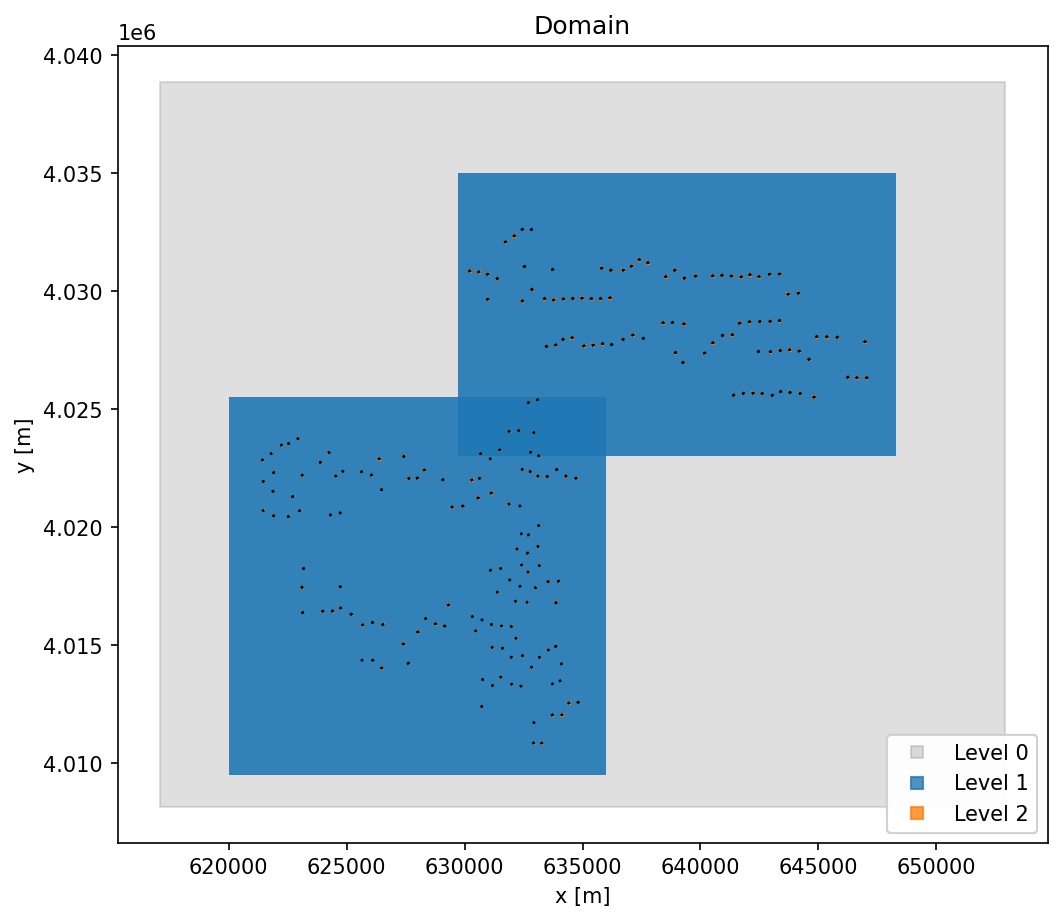

In [17]:
# Plot the domain (total domain)
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.plotDomain(ax=ax)
ax.axis('scaled')

In [18]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0   1056964608             10.0 x 10.0 x 10.0
       1   1725120000                5.0 x 5.0 x 5.0
       2     32338939                2.5 x 2.5 x 2.5
  TOTAL:   2814423547


In [19]:
# Write the input file
print(case.writeAMRWindInput('FarmRun2Test.inp'))

# --- Simulation time control parameters ---
time.stop_time                           = 32000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.1                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 2000                
time.checkpoint_start                    = 48000               
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
io.restart_file                          = /gpfs/lcheung/AWAKEN/Benchmark1/Phase1/PrecursorLayout/MMC_BM1_BigPrecursor/chk48000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model               